# Prompt to generate the code with reflexion 

1. Generate new columns, for example "week"
2. CoT with multi-step check
3. 

In [75]:
import os
import re
import string
import json
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np

In [76]:
# Read the CSV file into a Pandas DataFrame
# print(os.getcwd())
calendar_data = pd.read_csv("../data/calendar_data.csv")
print(f"The number of calendar data is {len(calendar_data)}.")

with open("../data/question.json") as json_file:
    json_data = json.load(json_file)
    # print(json_data[question_index])

print(f"The number of the question is {len(json_data)}.")
print(f"Selected question is: {json_data[0]['question']}.")
print(f"Selected answer is: {json_data[0]['answer']}.")

The number of calendar data is 20.
The number of the question is 46.
Selected question is: How many meetings do I have attended in total?.
Selected answer is: 18.


In [78]:
# convert the start and end time into datetime format (%Y-%m-%d %H:%M:%S)
def convert_date(calendar_data):   
    # Convert 'start' and 'end' columns to datetime objects
    calendar_data['start'] = pd.to_datetime(calendar_data['start'])
    calendar_data['end']   = pd.to_datetime(calendar_data['end'])
    # Format 'start' and 'end' columns into the desired string format
    calendar_data['start'] = calendar_data['start'].dt.strftime('%Y-%m-%d %H:%M:%S')
    calendar_data['end']   = calendar_data['end'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    
    calendar_data['start'] = pd.to_datetime(calendar_data['start'])
    calendar_data['end']   = pd.to_datetime(calendar_data['end'])
    # calendar_data['attendees'] = [ str(item) for item in calendar_data['attendees'] ]
    # weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    # calendar_data['weekday'] =[ weekdays[pd.to_datetime(calendar_data["start"][i], format='%Y-%m-%d %H:%M:%S').weekday()] for i in range(len(calendar_data['start']))]
    
    return calendar_data

calendar_data = convert_date(calendar_data)
# data type 'datetime64[ns]'
# today_date = pd.to_datetime('2024-04-02 09:02:30', format='%Y-%m-%d %H:%M:%S')


In [79]:
from datetime import datetime, timedelta
today = datetime.today()
next_tuesday = today + timedelta((1 - today.weekday() + 1) % 7)

print((today))

2024-04-05 17:31:59.172053


In [80]:

# MODEL = "gpt-4"
MODEL = "gpt-3.5-turbo"

question_index = 9 # for question test

In [81]:
def get_completion(MODEL, PROMPT):
    if MODEL == "gpt-4":
        # print(f"""Model is: gpt-4""")
        client = OpenAI(
            api_key=os.environ.get("OPENAI_API_KEY"),
        )
    else:
        # print(f"""Model is: gpt-3.5 turbo""")
        client = OpenAI()

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": PROMPT,
            }
        ],
        model=MODEL, 
    )

    # verify the output
    return chat_completion.choices[0].message.content

Use a Chain-of-Thought approach to break down the problem, analyze the date requirements, and then write the code in Python language. 

    For example, the output have the following format:
    ```python
    def query_dataframe(calendar_data):
        
        return answer
    ```

In [82]:
def get_prompt(question):
    
    PROMPT = f"""You are provided a calendar dataset. This calendar is a Pandas dataframe named calendar_data, columns = [ID, status, summary, start, end , duration, attendees].
    This DataFrame calendar_data includes all of your meeting schedule. 
    Provide a chain of thought for your reasoning, analyze the date requirement, filter dataframe, and then fill the python function <query_dataframe>. 
    First, based on the dataframe and question, breakdown the question into several steps; Second, implement those steps in Python using the datetime module and Pandas:

    The input dataframe calendar_data have following columns:
    - ID: meeting ID;
    - status: meeting status, including the following status: cancelled, confirmed, tentative, data type 'string'.
    - summary: meeting or event topic, data type 'string';
    - start: the start datetime of meeting, data type 'datetime64[ns]', and date format: '%Y-%m-%d %H:%M:%S'.;
    - end: the start datetime of meeting, data type 'datetime64[ns]', and date format: '%Y-%m-%d %H:%M:%S',;
    - duration: meeting duration, data type 'int64', and date format: second;
    - attendees: email address of people who attend the meeting, data type 'str', emails address are delimited by the line terminator.
    
    
    **instruction**
    - Provided python packages: 'datetime', 'pandas';
    - the python function is <query_dataframe> and the inpout is 'calendar_data';
    - all the questions use same timezone, thus don't have to convert the timezone;
    - if the today's date is required, use the floowing python code:
    ```python
    # get today's date, if the question is related to datetime, use today_date, otherwise ignore this code
    today_date = pd.to_datetime('2024-04-02 09:02:30', format='%Y-%m-%d %H:%M:%S')
    ```

    Ensure any code you provide can be executed with all required input and variables defined. 
    The output should be a markdown python code snippet formatted in the following schema, including the leading and trailing "```python" and "```":
    ```python
    def query_dataframe(calendar_data):

        <your code here>
        
        return answer
    ```    
    
    Here is the question: {question} 
    """
    return PROMPT



In [83]:
def get_python_code(llm_reply_with_code):
    _python_code_re_pattern = "```python\n(.*?)```"
    llm_reply_without_code = re.sub(
                _python_code_re_pattern, "", llm_reply_with_code, flags=re.DOTALL
                )
    python_code_list = re.findall(_python_code_re_pattern, llm_reply_with_code, re.DOTALL)
    return python_code_list[0]

## Prompt without reflexion

In [87]:
# About 2.2 mins to run the code

# GPT-4

result_summary = {'success': 0, 'wrong_answer': 0, 'error': 0}
question_answer_summary = {'question': '',
                           'generated_code': '',
                           'true_answer':'', 
                           'answer': ''
                        }

q_a_pair_solution_list_for_json = []
result_prompt = []

for i in range(5):
    result_summary = {'success': 0, 'wrong_answer': 0, 'error': 0}
    for q_a_pair in json_data: 
        PROMPT = get_prompt(q_a_pair['question'])
        llm_reply_with_code = get_completion(MODEL, PROMPT)
        try: 
            python_code_list = get_python_code(llm_reply_with_code)
        except Exception as E:
            print(repr(E))
            pass
        else:
            llm_reply_with_code = get_completion(MODEL, PROMPT)
            python_code_list = get_python_code(llm_reply_with_code)
        
        question_answer_summary['question'] = q_a_pair['question']
        question_answer_summary['true_answer'] = q_a_pair['answer']
        question_answer_summary['generated_code'] = python_code_list
        
        # print(f"""Question: {q_a_pair['question']}\n True answer: {q_a_pair['answer']}""")

        try:
            # define the generated <query_dataframe> function code 
            exec(python_code_list)
            answer = query_dataframe(calendar_data.copy())
        except Exception as E:
            question_answer_summary['answer'] = repr(E)
            print(f"""Non-executable code: {E}""")
            result_summary['error'] += 1
            pass
        else:
            try: 
                if str(q_a_pair['answer']) in str(answer):
                    question_answer_summary['answer'] = 'success'
                    result_summary['success'] += 1
                else:
                    question_answer_summary['answer'] = repr(answer)
                    print(f"""Question: {q_a_pair['question']}\n True answer: {q_a_pair['answer']}""")
                    print(f"""Wrong answer: {answer}""")
                    print(python_code_list)
                    result_summary['wrong_answer'] += 1
            except Exception as E:
                question_answer_summary['answer'] = repr(E)
                print(python_code_list)
                print(f"""Non-executable code: {E}""")
                result_summary['error'] += 1
                pass   
        
    result_prompt.append(result_summary.copy())
    q_a_pair_solution_list_for_json.append(question_answer_summary.copy())
    print(result_summary)

# save the result into JSON file.
# print(json.dumps(result_list, indent=4))
# with open('data.json', 'w', encoding='utf-8') as f:
#     json.dump(q_a_pair_solution_list_for_json, f, indent=4)
    

def query_dataframe(calendar_data):

    # Check if 'attendees' column contains the user's email address
    user_email = 'user@example.com'  # Replace this with the user's email address
    attended_meetings = calendar_data[calendar_data['attendees'].str.contains(user_email)]

    # Get the count of attended meetings
    total_attended_meetings = attended_meetings.shape[0]

    return total_attended_meetings

Question: How many meetings do I have attended in total?
 True answer: 18
Wrong answer: 0
def query_dataframe(calendar_data):
    import pandas as pd
    
    # get today's date
    today_date = pd.to_datetime('2024-04-02 09:02:30', format='%Y-%m-%d %H:%M:%S')
    
    # Filter the dataframe for meetings happening today
    today_meetings = calendar_data[(calendar_data['start'].dt.date == today_date.date())]
    
    # Find the latest scheduled meeting for today
    latest_meeting = today_meetings[today_meetings['start'] == today_meetings['start'].max()]
    
    # Get the meetin

## Prompt with error aware reflexion

 .dt accessor with datetimelike values

In [ ]:
def get_prompt_for_refine(question, generated_code):
    
    PROMPT = f"""Reevaluate your previous generated python code for the question: {question}. For this question, a calendar dataset is provided. This calendar is a Pandas dataframe named calendar_data, columns = [ID, status, summary, start, end , duration, attendees].
    check if the generated code mets the rules step by step, then rewrite the python code to ensure previous generated python code code can be executed with all required input and variables defined.
    
    The input dataframe calendar_data have following columns:
    - ID: meeting ID;
    - status: meeting status, including the following status: cancelled, confirmed, tentative, data type 'string'.
    - summary: meeting or event topic, data type 'string';
    - start: the start datetime of meeting, data type 'datetime64[ns]', and date format: '%Y-%m-%d %H:%M:%S'.;
    - end: the start datetime of meeting, data type 'datetime64[ns]', and date format: '%Y-%m-%d %H:%M:%S',;
    - duration: meeting duration, data type 'int64', and date format: second;
    - attendees: email address of people who attend the meeting, data type 'str', emails address are delimited by the line terminator.
    
    
    **rules**
    - The function name is 'query_dataframe';
    - The input is a dataFrame named 'calendar_data';
    - Provided python packages: 'datetime', 'pandas';
    - All the questions use same timezone, thus don't have to convert the timezone;
    - when count the number of meeting, make sure that meeting status consists of three status: cancelled, confirmed, tentative;
    - For analyze date range, don't forget 'this', 'next';
    - Ensures consistency in datetime comparison 

    - if the today's date is required, use the floowing python code:
    ```python
    # get today's date, if the question is related to datetime, use today_date, otherwise ignore this code
    today_date = pd.to_datetime('2024-04-02 09:02:30', format='%Y-%m-%d %H:%M:%S')
    ```
    
    
    The new python code should be a markdown python code snippet formatted in the following schema, including the leading and trailing "```python" and "```": Here are several code examples
    
    The new output should be a markdown python code snippet formatted in the following schema, including the leading and trailing "```python" and "```":
    ```python
    def query_dataframe(calendar_data):
        <your code here>
        
        return answer
    ```
    
    The previous generated code is:
    ```
    {generated_code}
    ```
    """
    return PROMPT



In [ ]:
    # - ensure that both sides of the comparison are in the same timezone
    # - if the question is related to datetime, then using the Pandas datetime to deal with datetime;
    # - if the question is related to datetime, ensure that both sides of the comparison have the same timezone information or both side have no timezone information.

In [ ]:
def get_prompt_with_error(question, generated_code, error_info):
    
    PROMPT = f"""You are expert in Python Debugging. For the question {question}, You have to analysis given python <Generated Code> and <Error> and generate new python code that handles the error. 
    For this question, a calendar dataset is provided. This calendar is a Pandas dataframe named calendar_data, columns = [ID, status, summary, start, end , duration, attendees].
    check the generated code, then rewrite the python code to ensure previous generated python code can be executed.
    
    The input dataframe calendar_data have following columns:
    - ID: meeting ID;
    - status: meeting status, including the following status: cancelled, confirmed, tentative, data type 'string'.
    - summary: meeting or event topic, data type 'string';
    - start: the start datetime of meeting, data type 'datetime64[ns]', and date format: '%Y-%m-%d %H:%M:%S'.;
    - end: the start datetime of meeting, data type 'datetime64[ns]', and date format: '%Y-%m-%d %H:%M:%S',;
    - duration: meeting duration, data type 'int64', and date format: second;
    - attendees: email address of people who attend the meeting, data type 'str', emails address are delimited by the line terminator.
    
    *Instructions*:
    - Generated code is able to handle the error;
    - The input is a dataFrame named 'calendar_data';
    
    
    The new output should be a markdown python code snippet formatted in the following schema, including the leading and trailing "```python" and "```":
    ```python
    def query_dataframe(calendar_data):

        <your code here>
        
        return answer
    ```
    
    *Generated Code*: {generated_code}
    
    *Error*: {error_info}
    """
    return PROMPT



In [ ]:
# Generated Code Check
def code_generate_check(question):
    # code generation
    PROMPT = get_prompt(question)
    llm_reply_with_code = get_completion(MODEL, PROMPT)
    python_code_list = get_python_code(llm_reply_with_code)
    # code check
    PROMPT_refine = get_prompt_for_refine(question, python_code_list)
    llm_refine_reply_with_code = get_completion(MODEL, PROMPT_refine)
    python_checked_code = get_python_code(llm_refine_reply_with_code)
    
    return python_checked_code



def exec_code_check(question, generated_code, error_info):
    PROMPT_reflexion = get_prompt_with_error(question, generated_code, error_info)
    llm_reply_with_code = get_completion(MODEL, PROMPT_reflexion)
    python_reflexion_code = get_python_code(llm_reply_with_code)
    
    return python_reflexion_code


In [ ]:

result_summary = {'success': 0, 'wrong_answer': 0, 'error': 0}
question_answer_summary = {'question': '',
                           'generated_code': '',
                           'true_answer':'', 
                           'answer': ''
                        }
q_a_pair_solution_list_for_json = []
result_prompt = []

for i in range(5):
    for q_a_pair in json_data: 
        python_code_list = code_generate_check(q_a_pair['question'])
        
        question_answer_summary['question'] = q_a_pair['question']
        question_answer_summary['true_answer'] = q_a_pair['answer']
        question_answer_summary['generated_code'] = python_code_list
        # print(f"""Question: {q_a_pair['question']}\n True answer: {q_a_pair['answer']}""")

        print(q_a_pair['question'])

        
        try:
            exec(python_code_list)
            answer = query_dataframe(calendar_data.copy())
        except Exception as E:
            question_answer_summary['answer'] = repr(E)
            print(f"""Non-executable code: {E}""")
            result_summary['error'] += 1
            pass
        else:
            try: 
                if q_a_pair['answer'] == answer:
                    question_answer_summary['answer'] = 'success'
                    result_summary['success'] += 1
                else:
                    question_answer_summary['answer'] = repr(answer)
                    print(f"""Wrong answer: {answer}""")
                    result_summary['wrong_answer'] += 1
            except Exception as E:
                question_answer_summary['answer'] = repr(E)
                print(f"""Non-executable code: {E}""")
                result_summary['error'] += 1
                pass   
        
    result_prompt.append(result_summary.copy())
    q_a_pair_solution_list_for_json.append(question_answer_summary.copy())
    print(result_summary)

# save the result into JSON file.
# print(json.dumps(result_list, indent=4))
# with open('data.json', 'w', encoding='utf-8') as f:
#     json.dump(result_list, f, indent=4)


How many meetings do I have attended in total?
Wrong answer: 17
How many events do I have scheduled for today?
Wrong answer: 2
How many attendees are there for the meeting with ID masbk72a24cb0a8k9c7jo0e9s6?
Wrong answer: 1
What is the longest meeting on my calendar, tell me the meeting ID?
How many events with duration longer than 1 hours?
How many meeting were cancelled in total?
How many events are scheduled today?
How many events are scheduled tomorrow?
Do I have me with natalia tomorrow, True or False?
How many meeting did I have yestaerday ?
How many meetings do I have for next 3 days?
Wrong answer: 3
What is the topic of my last meeting today?
Wrong answer: Security Best Practices
What is the topic of my next meeting?
Wrong answer: UI/UX Design
What is the minimum meeting time??
How many confirmed meetings are scheduled for tomorrow?
What is the average meeting duration?
What is my latest scheduled meeting for today? tell me meeting ID 
Wrong answer: maddn84w35db8y3u8n2jo0a5y1
W

<string>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


How many meetings which are yet to start this week?
Find the start time of next meeting?
Wrong answer: 2024-04-02 09:30:00
Find the end time of next meeting?
Wrong answer: 2024-04-02 11:00:00
Find the duration of meeting with id 'mahsm54f88qb0j5o8p3uo0a9v8'.?
How many meetings got confirmed?
{'success': 55, 'wrong_answer': 34, 'error': 3}
How many meetings do I have attended in total?
Wrong answer: 20
How many events do I have scheduled for today?
Wrong answer: 2
How many attendees are there for the meeting with ID masbk72a24cb0a8k9c7jo0e9s6?
Wrong answer: 1
What is the longest meeting on my calendar, tell me the meeting ID?
How many events with duration longer than 1 hours?
How many meeting were cancelled in total?
How many events are scheduled today?
How many events are scheduled tomorrow?
Do I have me with natalia tomorrow, True or False?
How many meeting did I have yestaerday ?
How many meetings do I have for next 3 days?
What is the topic of my last meeting today?
Non-executable c

# Prompt with reflexion and error rewrite

In [ ]:

result_summary = {'success': 0, 'wrong_answer': 0, 'error': 0}
question_answer_summary = {'question': '',
                           'generated_code': '',
                           'true_answer':'', 
                           'answer': ''
                        }
q_a_pair_solution_list_for_json = []
result_prompt = []


for q_a_pair in json_data: 
    python_code_list = code_generate_check(q_a_pair['question'])
    
    question_answer_summary['question'] = q_a_pair['question']
    question_answer_summary['true_answer'] = q_a_pair['answer']
    question_answer_summary['generated_code'] = python_code_list
    # print(f"""Question: {q_a_pair['question']}\n True answer: {q_a_pair['answer']}""")

    print(q_a_pair['question'])
    
    iter = 0
    error_index = True
    while(error_index and iter<3):
        iter += 1
        try:
            exec(python_code_list)
            answer = query_dataframe(calendar_data.copy())
            if (q_a_pair['answer'] == answer or True):
                error_index = False
                print(f"""Pass {iter}""")
        except Exception as E:
            print(f"""Recheck - Non-executable code type error: {E}""")
            python_code_list = exec_code_check(q_a_pair['question'], python_code_list, repr(E))
            pass
    
    try:
        exec(python_code_list)
        answer = query_dataframe(calendar_data.copy())
    except Exception as E:
        question_answer_summary['answer'] = repr(E)
        print(f"""Non-executable code: {E}""")
        result_summary['error'] += 1
        pass
    else:
        try: 
            if q_a_pair['answer'] == answer:
                question_answer_summary['answer'] = 'success'
                result_summary['success'] += 1
            else:
                question_answer_summary['answer'] = repr(answer)
                print(f"""Wrong answer: {answer}""")
                result_summary['wrong_answer'] += 1
        except Exception as E:
            question_answer_summary['answer'] = repr(E)
            print(f"""Non-executable code: {E}""")
            result_summary['error'] += 1
            pass   
    
    result_prompt.append(result_summary.copy())
    # q_a_pair_solution_list_for_json.append(question_answer_summary.copy())
print(result_summary)

# save the result into JSON file.
# print(json.dumps(result_list, indent=4))
# with open('data.json', 'w', encoding='utf-8') as f:
#     json.dump(result_list, f, indent=4)
    

How many meetings do I have attended in total?
Pass 1
How many events do I have scheduled for today?
Pass 1
How many attendees are there for the meeting with ID 'masbk72a24cb0a8k9c7jo0e9s6'?
Pass 1
Wrong answer: 1
What is the longest meeting on my calendar, tell me the meeting ID?
Pass 1
How many events with duration longer than 1 hours?
Pass 1
How many meeting were cancelled in total?
Pass 1
How many events are scheduled today?
Pass 1
How many events are scheduled tomorrow?
Pass 1
Do I have me with natalia tomorrow, True or False?
Pass 1
How many meeting did I have yestaerday ?
Pass 1
How many meetings do I have for next 3 days?
Pass 1
Wrong answer: 3
What is the topic of my previous meeting today?
Pass 1
Wrong answer: Database Architecture 
What is the topic of my next meeting?
Pass 1
Wrong answer: Database Architecture 
What is the minimum meeting time??
Pass 1
How many confirmed meetings are scheduled for tomorrow?
Pass 1
What is the average meeting duration?
Pass 1
Wrong answer: 3

<string>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


What is my latest scheduled meeting for today? tell me meeting ID 
Pass 1
Wrong answer: maddn84w35db8y3u8n2jo0a5y1
What is the total meeting duration for today?
Pass 1
How many meetings that last more than 2 hours?
Pass 1
Do I have meeting in next 2 hours, True or False?
Pass 1
Wrong answer: False
Do I have meeting in today afternoon, True or False?
Pass 1
How many meetings do I have meeting in this afternoon?
Pass 1
Wrong answer: 11
How many meetings have more than 10 attendees?
Pass 1
How many meetings were scheduled for last weekend?
Pass 1
Wrong answer: 3
How many meetings did I attended last week?
Pass 1
Wrong answer: 1
How many meetings did I attended last three days?
Pass 1
Wrong answer: 2
How many meetings do I have this tuesday?
Pass 1
Wrong answer: 8
Do I have meeting this tuesday, True or False?
Pass 1
Do I have meeting tuesday morning this week, True or False?
Recheck - Non-executable code type error: 'DatetimeProperties' object has no attribute 'week'
Pass 2
How many meeti

## Performance analysis

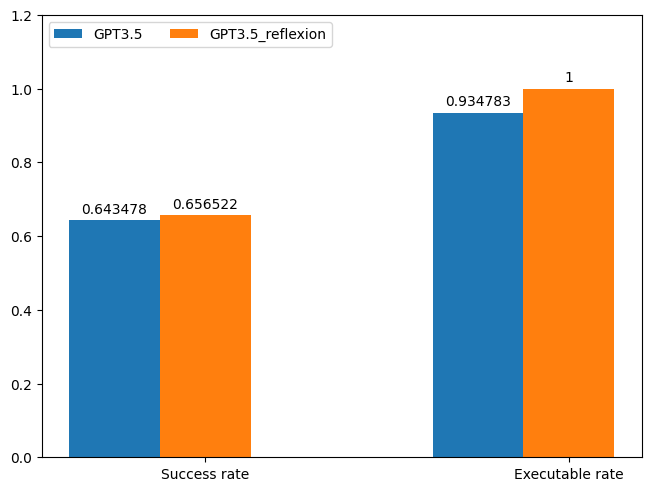

In [ ]:
result_prompt = [
    {'success': 148, 'wrong_answer': 67, 'error': 15}
]

result_prompt_with_refine = [
    {'success': 143, 'wrong_answer': 78, 'error': 9}
]

result_prompt_with_reflexion = [
    {'success': 30, 'wrong_answer': 16, 'error': 0},
    {'success': 28, 'wrong_answer': 18, 'error': 0},
    {'success': 33, 'wrong_answer': 13, 'error': 0},
    {'success': 33, 'wrong_answer': 13, 'error': 0},
    {'success': 27, 'wrong_answer': 19, 'error': 0}
]




# Calculate average success rate and average error rate for each list
def calculate_average_rates(result_list):
    total_records = len(result_list)
    if total_records == 0:
        return 0, 0
    total_questions = sum(result_list[0].values())
    success_sum = sum(result['success'] for result in result_list)
    error_sum = sum(result['error'] for result in result_list)
    average_success_rate = success_sum / total_records/total_questions
    average_exec_rate = 1- error_sum / total_records/total_questions
    return average_success_rate, average_exec_rate


result_p_3_5_avg_success, result_p_3_5_avg_exec = calculate_average_rates(result_prompt)
result_p_4_w_r_avg_success, result_p_4_w_r_avg_exec = calculate_average_rates(result_prompt_with_reflexion)

performance = ("Success rate", "Executable rate")
penguin_means = {
    'GPT3.5': (result_p_3_5_avg_success, result_p_3_5_avg_exec),
    'GPT3.5_reflexion': (result_p_4_w_r_avg_success, result_p_4_w_r_avg_exec),
}

x = np.arange(len(performance))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width, performance)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1.2)

plt.show()

baseline GPT_4   baseline gpt3.5finutuned production   gpt4 prompt gpt3.5 prompt

## BACKUP - Prompt without reflexion



In [ ]:
result_summary = {'success': 0, 'wrong_answer': 0, 'error': 0}
question_answer_summary = {'question': '',
                           'generated_code': '',
                           'true_answer':'', 
                           'answer': ''
                        }
q_a_pair_solution_list_for_json = []
result_prompt = []


for q_a_pair in json_data: 
    PROMPT = get_prompt(q_a_pair['question'])
    llm_reply_with_code = get_completion(MODEL, PROMPT)
    python_code_list = get_python_code(llm_reply_with_code)
    
    question_answer_summary['question'] = q_a_pair['question']
    question_answer_summary['true_answer'] = q_a_pair['answer']
    question_answer_summary['generated_code'] = python_code_list
    
    print(f"""Question: {q_a_pair['question']}\n True answer: {q_a_pair['answer']}""")

    try:
        exec(python_code_list)
    except Exception as E:
        question_answer_summary['answer'] = repr(E)
        print(f"""Non-executable code: {E}""")
        result_summary['error'] += 1
        pass
    else:
        try: 
            if q_a_pair['answer'] == answer:
                question_answer_summary['answer'] = 'success'
                result_summary['success'] += 1
            else:
                question_answer_summary['answer'] = repr(answer)
                print(f"""Wrong answer: {answer}""")
                result_summary['wrong_answer'] += 1
        except Exception as E:
            question_answer_summary['answer'] = repr(E)
            print(f"""Non-executable code: {E}""")
            result_summary['error'] += 1
            pass   
    
    result_prompt.append(result_summary.copy())
    # q_a_pair_solution_list_for_json.append(question_answer_summary.copy())
    # print(result)

# save the result into JSON file.
# print(json.dumps(result_list, indent=4))
# with open('data.json', 'w', encoding='utf-8') as f:
#     json.dump(result_list, f, indent=4)
    